# M1. Actividad

Realizado por Andrea Corona Arroyo A01366768

Link a Github: https://github.com/AndreaCorona523/MultiAgentes.git

Para este problema, deberás entregar, de manera individual, un informe en un cuaderno de Jupyter (de no usar Jupyter se tendrá que entregar un PDF) que estudie las estadísticas de un robot de limpieza reactivo, así como el enlace al repositorio en Github del código desarrollado para esta actividad. El código debe ajustarse al estilo solícito en el siguiente documento.

Dado:

- Habitación de MxN espacios.
- Número de agentes.
- Porcentaje de celdas inicialmente sucias.
- Tiempo máximo de ejecución.

Realiza la siguiente simulación:

- Inicializa las celdas sucias (ubicaciones aleatorias).
- Todos los agentes empiezan en la celda [1,1].

En cada paso de tiempo:
- Si la celda está sucia, entonces aspira.
- Si la celda está limpia, el agente elige una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elige la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
- Se ejecuta el tiempo máximo establecido

## Imports

Antes de empezar a crear el modelo de los robots de limpieza con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`
- `matplotlib`

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes. 

In [1]:
# La clase `Model` se hace cargo de los atributos a nivel del modelo, maneja los agentes. 
# Cada modelo puede contener múltiples agentes y todos ellos son instancias de la clase `Agent`.
from mesa import Agent, Model 

# Debido a que se permitirán varios agentes por celda elegimos `MultiGrid`.
from mesa.space import MultiGrid

# Con `SimultaneousActivation` hacemos que todos los agentes se activen de manera simultanea.
from mesa.time import SimultaneousActivation

# Vamos a hacer uso de `DataCollector` para obtener el grid completo cada paso (o generación) y lo usaremos para graficarlo.
from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos.
import numpy as np
import pandas as pd
import random

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Creación del Modelo

In [2]:
def obtenerHabitacion(model):
    '''
    Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
    param model: El modelo del cual optener el grid.
    return una matriz con la información del grid del agente.
    '''
    grid = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        if isinstance(cell_content[0], Floor) and len(cell_content) == 1 :
            grid[x][y] = cell_content[0].status
        else :
            grid[x][y] = 0
    return grid

class VacuumAgent(Agent):
    '''
    Representa a un robot de limpieza.
    '''
    def __init__(self, unique_id, model):
        '''
        Agente representa un robot de limpieza, se inicializa con un id, con una lista de celdas limpiadas vacía, 
        una lista de movimientos hechos, y con el numero de movimientos realizados en 0.
        '''
        super().__init__(unique_id, model)
        self.movements = []
        self.numMovimientos = 0
        self.nextPos = None
        self.possibleMoves = []
        
    def cleanCell(self):
        '''
        Este método realiza la limpieza de la celda.
        '''
        #Limpia la celda
        contents = model.grid.get_cell_list_contents([self.pos])
        for cell in contents:
            if isinstance(cell, Floor):
                cell.status = cell.CLEAN
                #Registra la celda en la lista de movimientos
                self.movements.append(cell.pos)
                    
                
    def findDirtyCells(self):
        '''
        Este método encuentra las celdas sucias alrededor del agente
        '''
        
        #Obtiene las celdas vecinas a ese agente
        neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)
        
        #Determina si las celdas están sucias o si se puede mover a esa celda, de manera 
        #que no existan dos agentes en la misma celda al mismo tiempo.
        for neighbor in neighbours:
            if isinstance(neighbor, Floor):
                if neighbor.status == neighbor.DIRTY and not neighbor.pos in model.cellsToBeClean:
                        self.possibleMoves.append(neighbor.pos)
                    
    
    def move(self):
        '''
        Este método determina el siguiente movimiento del agente.
        '''
        x = self.pos[0]
        y = self.pos[1]
        coords = (x,y)
        #Si tiene movimientos posibles eligue aleatoriamente uno.
        if len(self.possibleMoves) > 0:
            coords = random.choice(self.possibleMoves)
        else:
            #Si no tiene movimientos posibles, eligue un movimiento aleatoriamente, 
            #bajo la condición que no sea la misma celda o alguna celda donde haya estado anteriormente.
            #Intenta hasta un máximo de 5 veces, no coincidir con otro agente en la misma celda.
            tries_left = 5
            while (coords == self.pos or coords in self.movements or coords in model.cellsToBeClean) and tries_left > 0 :
                x = random.randint(self.pos[0] - 1 ,self.pos[0] + 1)
                y = random.randint(self.pos[1] - 1 ,self.pos[1] + 1)
                coords = (x,y)
                if coords in model.cellsToBeClean:
                    tries_left -= 1

        self.nextPos = coords
        model.cellsToBeClean.append(coords)

                   
    def step(self):
        '''
        En este método el agente realiza las acciones del agente por cada paso.
        '''
        
        #limpia la celda donde está
        self.cleanCell()
        
        #Encuentra las celdas sucias alrededor de si mismo
        self.findDirtyCells()
        
        #Se determina una nueva posicion aleatoriamente
        self.move()
        
        #Limpia la lista de celdas sucias
        self.possibleMoves.clear()
        
        #Se suma 1 a los movimientos realizados
        self.numMovimientos += 1
                
    def advance(self):
        '''
        Define el nuevo estado calculado del método step.
        '''
        model.grid.move_agent(self, self.nextPos)

class Floor(Agent):
    '''
    Representa a una celda del piso.
    '''
    DIRTY = 0.5
    CLEAN = 1.0
    
    def __init__(self, unique_id, model):
        '''
        Agente representa una celda del piso, se inicializa con un id y 
        con el status de limpio que fue pasado como parámetro.
        '''
        super().__init__(unique_id, model)
        self.status = self.CLEAN

class VacuumModel(Model):
    '''
    Define el modelo de la habitación donde se encuentran los robots de limpieza.
    '''
    def __init__(self, num, width, height, ptg_dirty_cells):
        self.grid = MultiGrid(width, height, True)
        self.numCells = width * height
        self.schedule = SimultaneousActivation(self)
        self.cellsToBeClean = []
        self.ptgCleanedCells =  0
        self.numDirtyCells = int((width * height) * ptg_dirty_cells)
        
        #Posicionar celdas sucias de forma aleatoria
        
        listEmptyCells = list(self.grid.empties)
        for cell in range(self.numDirtyCells):
            emptyCell = random.choice(listEmptyCells)
            floor = Floor(emptyCell, self)
            floor.status = floor.DIRTY
            self.grid.place_agent(floor, emptyCell)
            self.schedule.add(floor)
            listEmptyCells.remove(emptyCell)
        
        #Posicionar celdas limpias
        for cell in listEmptyCells:
            floor = Floor(cell, self)
            self.grid.place_agent(floor, cell)
            self.schedule.add(floor)
            
        #Posicionar agentes en celda (1,1)
        for agent in range(num):
            a = VacuumAgent(agent, self)
            self.grid.place_agent(a, (1, 1))
            self.schedule.add(a)
            
        # Aquí definimos con colector para obtener la habitación y el número de movimientos totales.
        self.datacollector = DataCollector(
            model_reporters={'Habitacion': obtenerHabitacion},
            agent_reporters={'Movimientos': lambda a: getattr(a, 'numMovimientos', None)},
        )
    
    def step(self):
        '''
        En cada paso el colector tomará la información que se definió y almacenará el grid para luego graficarlo.
        '''
        self.datacollector.collect(self)
        self.schedule.step()
        
    def allCellEmpty(self):
        '''
        Este método determina si se han limpiado todas las celdas de la habitación
        '''
        cleanCells = 0
        for cell in self.grid.coord_iter():
            contents, x, y = cell
            for content in contents:
                if isinstance(content,Floor) and content.status == content.CLEAN:
                    cleanCells += 1
        self.ptgCleanedCells = (cleanCells / model.numCells) * 100
        if cleanCells == (self.numCells):
            return True
        return False

A continuación se corre el modelo:

In [3]:
# Definimos el tamaño del Grid
M = 15
N = 15

# Definimos el porcentaje de celdas sucias
POR_DIRTY_CELLS = 0.6

# Definimos el número de agentes
NUM_AGENTS = 5

# Definimos tiempo máximo (segundos)
MAX_TIME = 0.09

# Registramos el tiempo de inicio y corremos el modelo
num_generations = 0

start_time = time.time()
model = VacuumModel(NUM_AGENTS, M, N, POR_DIRTY_CELLS)
while time.time() - start_time < MAX_TIME and not model.allCellEmpty():
    num_generations += 1
    model.step()
    end_time = time.time()

Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [4]:
all_grid = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando matplotlib

In [5]:
%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.gray)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=num_generations)

In [6]:
anim

Se imprimen los resultados obtenidos:

In [7]:
movimientos = model.datacollector.get_agent_vars_dataframe()
print("Tiempo: " + str(datetime.timedelta(seconds=(end_time - start_time))) + " / " + str(datetime.timedelta(seconds=(MAX_TIME))))
print("Porcentaje de celdas limpias después del término de la simulación: " + str(model.ptgCleanedCells))
print("Número de movimientos realizados por todos los agentes: " , movimientos.tail()["Movimientos"].sum())

Tiempo: 0:00:00.075801 / 0:00:00.090000
Porcentaje de celdas limpias después del término de la simulación: 100.0
Número de movimientos realizados por todos los agentes:  350.0


## Pruebas

A continuación, se corre el modelo 3 veces. En cada ocasión se modificó el tiempo y el porcentaje de celdas sucias. Asimismo, en cada ocasión, se corre 100  veces, almacenando la cantidad de agentes, el tiempo utilizado,  la cantidad de movimientos y el porcentaje de celdas limpias en cada iteracion. 

Por cada prueba se grafica la información recolectada de la siguiente manera:
- La primera gráfica muestra la comparación entre la cantidad de agentes y el tiempo utilizado.
- La segunda gráfica muestra la comparación entre la cantidad de agentes y la cantidad total de movimientos
- La tercera gráfica muestra la comparación entre la cantidad de agentes y el porcentaje de celdas limpias cuando terminó la simulación.

## Prueba 1

Se definen los parámetros de la prueba:

In [8]:
N_times = 100
N_times_iter = N_times

# Definimos el tamaño del Grid
M = 15
N = 15

# Definimos el porcentaje de celdas sucias a 0.5 
ptgDirtyCells1 = 0.5

# Definimos tiempo máximo a 0.06 segundos
maxTime1 = 0.06

Se realiza la prueba:

In [9]:
#Se almacena la información de las corridas
list_agents = []
list_time = []
list_movements = []
list_porcentage = []

while N_times_iter > 0:
    num_generations = 0
    # Definimos el número de agentes aletoriamente entre 1 y 20
    NUM_AGENTS = random.randint(1,20)

    start_time = time.time()
    model = VacuumModel(NUM_AGENTS, M, N, ptgDirtyCells1)
    while time.time() - start_time < maxTime1 and not model.allCellEmpty():
        num_generations += 1
        model.step()
        end_time = time.time()
    
    N_times_iter -= 1
    movimientos = model.datacollector.get_agent_vars_dataframe()
    
    allmovements = movimientos.tail()["Movimientos"].sum()
    
    list_agents.append(NUM_AGENTS)
    list_time.append(end_time - start_time)
    list_movements.append(allmovements)
    list_porcentage.append(model.ptgCleanedCells)
    

Se almacenan los datos en un DataFrame:

In [10]:
d = {'Num Agentes': list_agents, 
     'Tiempo':list_time, 
     'Movimientos':list_movements, 
     '% Celdas Limpias':list_porcentage}
data = pd.DataFrame(data=d)

## Prueba 2

Se definen los parámetros de la prueba:

In [11]:
N_times = 100
N_times_iter = N_times

# Definimos el tamaño del Grid
M = 15
N = 15

# Definimos el porcentaje de celdas sucias a 0.75
ptgDirtyCells2 = 0.75

# Definimos tiempo máximo a 0.09 segundos
maxTime2 = 0.09

Se realiza la prueba:

In [12]:
#Se almacena la información de las corridas
list_agents2 = []
list_time2 = []
list_movements2 = []
list_porcentage2 = []

while N_times_iter > 0:
    num_generations = 0
    # Definimos el número de agentes aletoriamente entre 1 y 20
    NUM_AGENTS = random.randint(1,20)

    start_time = time.time()
    model = VacuumModel(NUM_AGENTS, M, N, ptgDirtyCells2)
    while time.time() - start_time < maxTime2 and not model.allCellEmpty():
        num_generations += 1
        model.step()
        end_time = time.time()
    
    N_times_iter -= 1
    movimientos = model.datacollector.get_agent_vars_dataframe()
    
    allmovements = movimientos.tail()["Movimientos"].sum()
    
    list_agents2.append(NUM_AGENTS)
    list_time2.append(end_time - start_time)
    list_movements2.append(allmovements)
    list_porcentage2.append(model.ptgCleanedCells)

Se almacenan los datos en un DataFrame:

In [13]:
d2 = {'Num Agentes': list_agents2, 
     'Tiempo':list_time2, 
     'Movimientos':list_movements2, 
     '% Celdas Limpias':list_porcentage2}
data2 = pd.DataFrame(data=d2)

## Prueba 3

Se definen los parámetros de la prueba:

In [26]:
N_times = 100
N_times_iter = N_times

# Definimos el tamaño del Grid
M1 = 20
N1 = 20

# Definimos el porcentaje de celdas sucias a 0.75
ptgDirtyCells3 = 0.85

# Definimos tiempo máximo a 0.08 segundos
maxTime3 = 0.08

Se realiza la prueba:

In [27]:
#Se almacena la información de las corridas
list_agents3 = []
list_time3 = []
list_movements3 = []
list_porcentage3 = []

while N_times_iter > 0:
    num_generations = 0
    # Definimos el número de agentes aletoriamente entre 1 y 20
    NUM_AGENTS = random.randint(1,20)

    start_time = time.time()
    model = VacuumModel(NUM_AGENTS, M1, N1, ptgDirtyCells3)
    while time.time() - start_time < maxTime3 and not model.allCellEmpty():
        num_generations += 1
        model.step()
        end_time = time.time()
    
    N_times_iter -= 1
    movimientos = model.datacollector.get_agent_vars_dataframe()
    
    allmovements = movimientos.tail()["Movimientos"].sum()
    
    list_agents3.append(NUM_AGENTS)
    list_time3.append(end_time - start_time)
    list_movements3.append(allmovements)
    list_porcentage3.append(model.ptgCleanedCells)

Se almacenan los datos en un DataFrame:

In [28]:
d3 = {'Num Agentes': list_agents3, 
     'Tiempo':list_time3, 
     'Movimientos':list_movements3, 
     '% Celdas Limpias':list_porcentage3}
data3 = pd.DataFrame(data=d3)

## Gráficas

Se gráfican los datos de las pruebas:

## Prueba 1

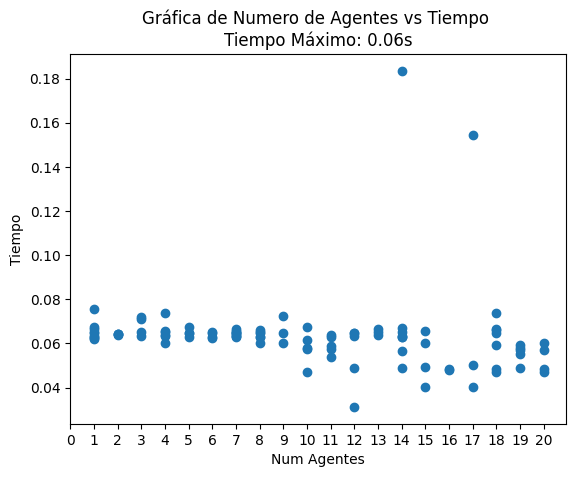

In [29]:
# Gráfica de Numero de Agentes vs Tiempo
plt.scatter(data['Num Agentes'],data['Tiempo'])
plt.xlabel('Num Agentes')
plt.ylabel('Tiempo' )
plt.title('Gráfica de Numero de Agentes vs Tiempo \nTiempo Máximo: ' + str(maxTime1) + 's')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

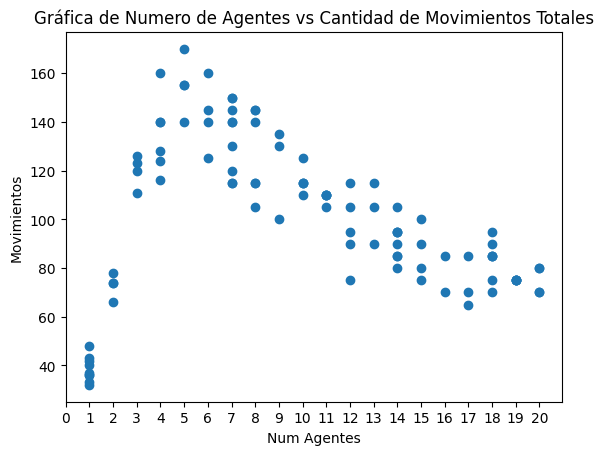

In [30]:
# Gráfica de Numero de Agentes vs Cantidad de Movimientos Totales
plt.scatter(data['Num Agentes'],data['Movimientos'])
plt.xlabel('Num Agentes')
plt.ylabel('Movimientos')
plt.title('Gráfica de Numero de Agentes vs Cantidad de Movimientos Totales')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

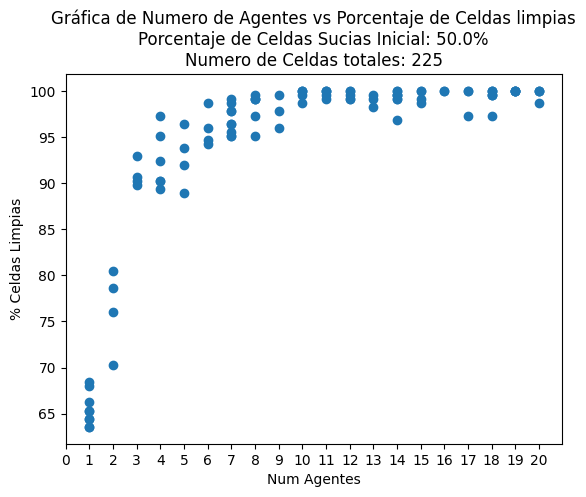

In [31]:
# Gráfica de Numero de Agentes vs Porcentaje de Celdas limpias
plot = plt.scatter(data['Num Agentes'],data['% Celdas Limpias'])
plt.xlabel('Num Agentes')
plt.ylabel('% Celdas Limpias')
plt.title('Gráfica de Numero de Agentes vs Porcentaje de Celdas limpias\nPorcentaje de Celdas Sucias Inicial: ' + str(ptgDirtyCells1 * 100) + '%\nNumero de Celdas totales: '+ str(M*N))
plt.xticks(np.arange(0, 21, step=1))
plt.show()

## Prueba 2

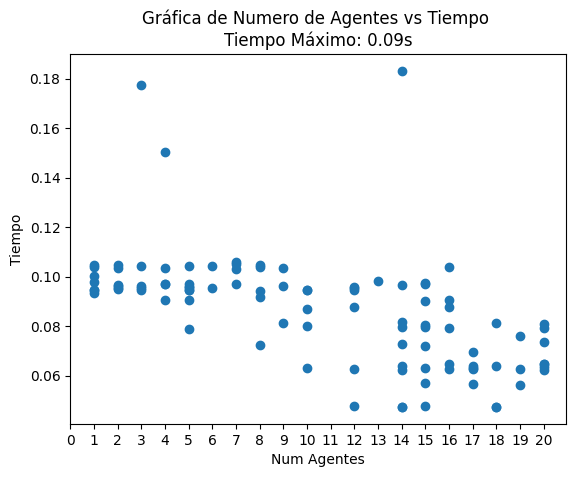

In [32]:
# Gráfica de Numero de Agentes vs Tiempo
plt.scatter(data2['Num Agentes'],data2['Tiempo'])
plt.xlabel('Num Agentes')
plt.ylabel('Tiempo' )
plt.title('Gráfica de Numero de Agentes vs Tiempo \nTiempo Máximo: ' + str(maxTime2) + 's')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

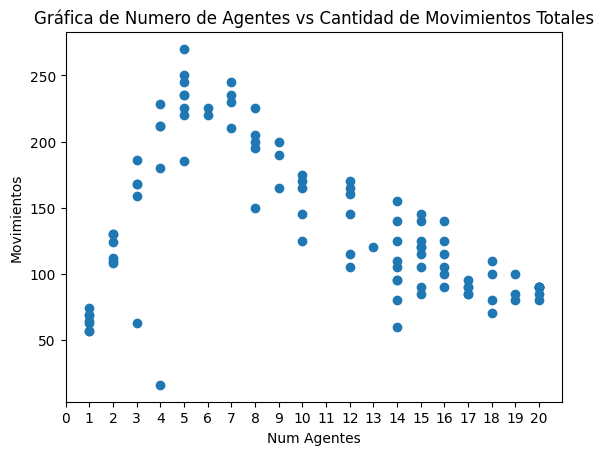

In [33]:
# Gráfica de Numero de Agentes vs Cantidad de Movimientos Totales
plt.scatter(data2['Num Agentes'],data2['Movimientos'])
plt.xlabel('Num Agentes')
plt.ylabel('Movimientos')
plt.title('Gráfica de Numero de Agentes vs Cantidad de Movimientos Totales')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

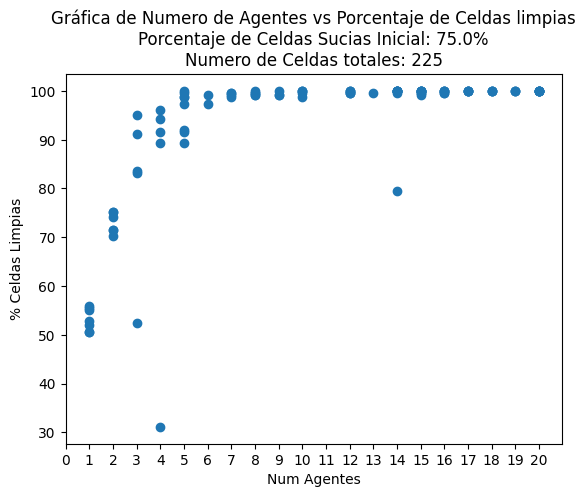

In [34]:
# Gráfica de Numero de Agentes vs Porcentaje de Celdas limpias
plot = plt.scatter(data2['Num Agentes'],data2['% Celdas Limpias'])
plt.xlabel('Num Agentes')
plt.ylabel('% Celdas Limpias')
plt.title('Gráfica de Numero de Agentes vs Porcentaje de Celdas limpias\nPorcentaje de Celdas Sucias Inicial: ' + str(ptgDirtyCells2 * 100) + '%\nNumero de Celdas totales: '+ str(M*N))
plt.xticks(np.arange(0, 21, step=1))
plt.show()

## Prueba 3

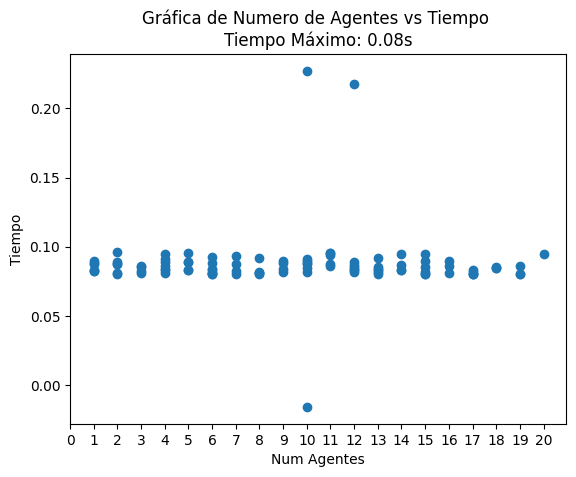

In [35]:
# Gráfica de Numero de Agentes vs Tiempo
plt.scatter(data3['Num Agentes'],data3['Tiempo'])
plt.xlabel('Num Agentes')
plt.ylabel('Tiempo' )
plt.title('Gráfica de Numero de Agentes vs Tiempo \nTiempo Máximo: ' + str(maxTime3) + 's')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

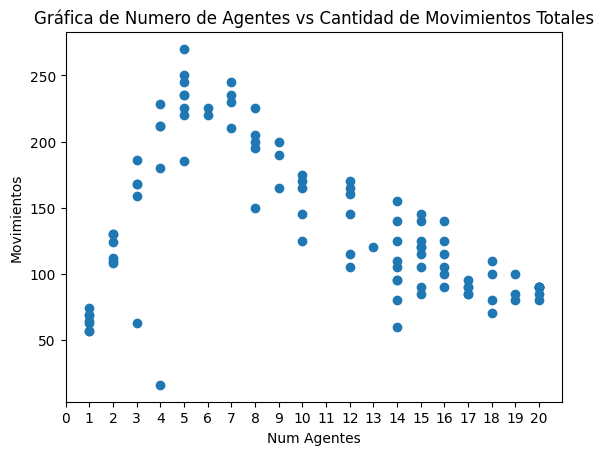

In [36]:
# Gráfica de Numero de Agentes vs Cantidad de Movimientos Totales
plt.scatter(data2['Num Agentes'],data2['Movimientos'])
plt.xlabel('Num Agentes')
plt.ylabel('Movimientos')
plt.title('Gráfica de Numero de Agentes vs Cantidad de Movimientos Totales')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

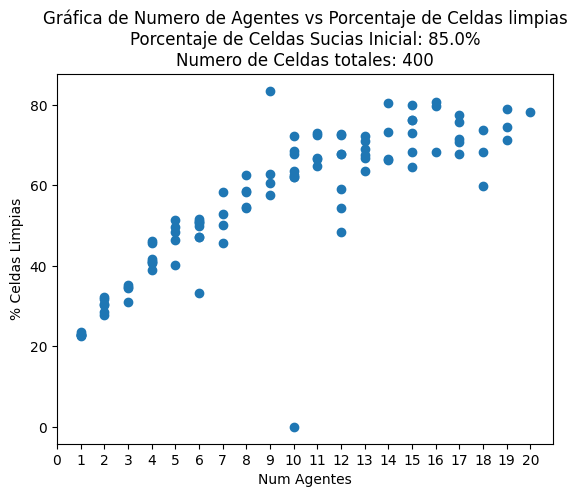

In [38]:
# Gráfica de Numero de Agentes vs Porcentaje de Celdas limpias
plot = plt.scatter(data3['Num Agentes'],data3['% Celdas Limpias'])
plt.xlabel('Num Agentes')
plt.ylabel('% Celdas Limpias')
plt.title('Gráfica de Numero de Agentes vs Porcentaje de Celdas limpias\nPorcentaje de Celdas Sucias Inicial: ' + str(ptgDirtyCells3 * 100) + '%\nNumero de Celdas totales: '+ str(M1*N1))
plt.xticks(np.arange(0, 21, step=1))
plt.show()

## Análisis
De acuerdo a las gráficas obtenidas, se obtuvieron los siguientes resultados:

Se puede observar como el tiempo parece disminuir ligeramente al aumentar el número de agentes en las pruebas 1 y 2, sin embargo, también se puede observar que este no es el caso siempre. Inclusive en iteraciones con el mismo número de agentes, se puede ver cómo entre sí, llega a aumentar o a disminuir el porcentaje. Esto se puede deber a que los movimientos de los robots de limpieza son aleatorios; si bien al encontrar celdas sucias se reduce la cantidad de posibilidades, esta se genera en cada paso, por lo que el movimiento es ligeramente más informado pero aleatorio. Asimismo, se puede observar que al aumentar el número de celdas como fue el caso de la prueba número 3, donde se aumentaron las celdas totales de 225 a 400, la diferencia conforme aumenta el número de agentes deja de ser notoria. Esto se puede deber a que se está ocupando casi o todo el tiempo disponible para poder realizar la limpieza de las celdas. 

En cuanto a la cantidad de movimientos de acuerdo a la cantidad de agentes, se puede observar que a partir de 5 agentes el número de movimientos va disminuyendo, conforme la cantidad de agentes aumenta, lo cual es el caso de todas las pruebas. Asimismo, se puede observar cómo antes de llegar a 5 agentes, la cantidad de movimientos aumenta ligeramente al ir aumentando más agentes. Esto nos indica que al haber pocos agentes, se requieren de más movimientos para realizar la limpieza de las celdas. De igual manera, nos indica que entre más agentes haya, si bien los movimientos son aleatorios, estos requieren de menos movimientos para poder limpiar todas las celdas. Este es el caso, dado que se le indicó al agente que procurara no repetir celdas con otros agentes, de manera que en cada iteración, se pudieran limpiar la mayor cantidad de celdas, por ende, reduciendo la cantidad total de movimientos. 
    
En cuanto al porcentaje de celdas que fueron limpiadas en comparación a la cantidad de agentes, se puede observar que en todos los casos, conforme aumento el número de agentes, aumentó el porcentaje de celdas limpias en comparación a iteraciones donde se cuenta con una menor cantidad. En el primer caso de prueba donde sólo se contaba con la mitad de las celdas sucias se muestra que a partir de los 3 agentes en todos los casos se terminó con más del 85% de las celdas limpias. En el caso de la segunda prueba, donde se tenía el 75% de las celdas sucias, se muestra que se a partir de los 5 agentes el porcentaje no bajo de 80%, salvo en una ocasión, donde el porcentaje fue de un poco menos del 80%. Finalmente, en el caso de prueba 3, se tiene que se tuvo un mínimo de 20% de celdas limpias contando con un sólo agente y que fue aumentando progresivamente hasta llegar a  máximo de 80% de celdas limpias con 20 agentes. Esto nos indica que las indicaciones proporcionadas al agente, es decir, que eliga aleatoriamente uan celda sucia de su alrededor e que intente no repetir una misma ubicación y no repetir celdas con otros agentes, han sido acertadas para lograr un porcentaje de limpieza aceptable a pesar de la poca cantidad de agentes que pueda haber. No obstante, se pueden visualizar casos atípicos en las gráficas donde el porcentaje de celdas limpias no es tan alto a pesar de que la cantidad de agentes no lo es, esto se puede explicar debido al hecho de que los movimientos son aleatorios, por lo que cabe la posibilidad que haya celdas que, sin importar la cantidad de agentes, puedan nunca ser encontradas. Lo anterior nos indica una posible área de oportunidad para poder mejorar la asertividad de los movimientos de los agentes y así, poder asegurar que entre más agentes haya se logre el 100% con seguridad.

## Conclusiones

De acuerdo a lo analizado, se puede concluir que el algoritmo planteado en el cual los agentes realizan movimientos aleatorios, basándose en las celdas sucias que encuentra a su alrededor y en no repetir movimientos anteriores, así como evitar coincidir con otros robots de limpieza, fue efectivo, dado que en las diferentes ejecuciones con un diferente número de agentes, se vio un resultado considerablemente bueno. No obstante, la variación entre las pruebas dependiendo de la cantidad de celdas inicialmente sucias, así como de la cantidad de tiempo máximo a la disposición de los agentes, nos indica que hay áreas de mejora en la implementación para poder ofrecer resultados más constantes y mejorar los porcentajes de limpieza, a pesar de contar con menos agentes.

En cuanto a las mejoras que se podrían aplicar, sería ofrecerle más información al agente para poder tomar movimientos más asertivos. Una manera de hacerlo sería que cada agente fuera guardando las celdas sucias que encuentra en una lista a la cual todos los agentes tengan acceso, de manera que los agentes puedan digirise hacia zonas que presenten una cantidad considerable de celdas sucias. De esta manera, se desplegarían una mayor cantidad de agentes en zonas muy sucias, de manera que se pudieran concentrar los esfuerzos de los robots y se pudiera realizar la limpieza en dicha zona mucho más rápido, aumentando así el porcentaje de celdas limpias al finalizar el tiempo. Otra manera sería configurar al agente para que el se haga responsable de limpiar todas las celdas sucias que ese mismo agente vaya encontrando, de manera que sus movimientos fueran más dirigidos, quitándole la aleatoridad a los movimientos y pudieron asegurar que hubiera la menor cantidad de movimientos "inútiles", es decir, en los cuales no se traslada a celdas limpias. Pudiendo así mejorar el porcentaje de celdas limpias para el final de la ejecución. 

En conclusión, los resultados mostraron que los resultados pueden ser mejorados al realizar pequeños cambios en la programación de los agentes de manera que al poseer mayor información, pudieran realizar movimientos más asertivos que permitieran obtener mejores resultados. De igual manera, al igual que con todo programa, queda abierta la posibilidad de mejorar la implementación a futuro para obtener mejores resultados, y que estos sean constantes sin importar la distribución de las celdas sucias, la cantidad de las mismas, o la cantidad de agentes desplegados. Asimismo, se tiene la posibilidad de optimizar la implementación realizada para poder reducir los tiempos de ejecución entre cada corrida del modelo. 